In [3]:
!pip install visualkeras

  Obtaining dependency information for aggdraw>=1.3.11 from https://files.pythonhosted.org/packages/da/05/8912c901a3965ec7117d6cc33eaec3888c717611f72ce69d8be62a01d149/aggdraw-1.3.18-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 18.9 MB/s eta 0:00:00a 0:00:01


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
import visualkeras

# Define paths
base_path = '/kaggle/input/task5-aml-satellite/'

X_train_smote = np.load(base_path + "X_train_smote.npy")
y_train_smote = np.load(base_path + "y_train_smote.npy")

X_test = np.load(base_path + "X_test_processed.npy")
y_test = np.load(base_path + "y_test.npy")

X_val = np.load(base_path + "X_val_processed.npy")
y_val = np.load(base_path + "y_val.npy")

In [10]:
base_path_ = '/kaggle/input/satellite/data'
labels

['cloudy', 'desert', 'green_area', 'water']

Number of images in each class:
cloudy: 1500 images
desert: 1131 images
green_area: 1500 images
water: 1500 images


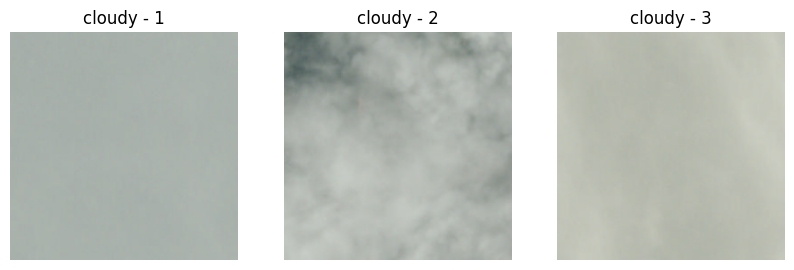

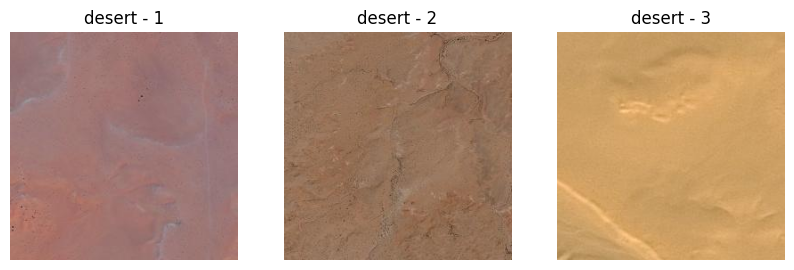

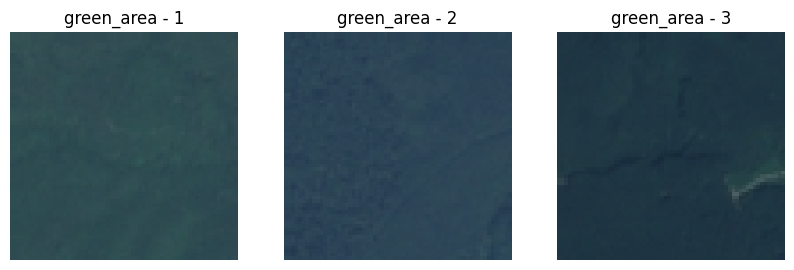

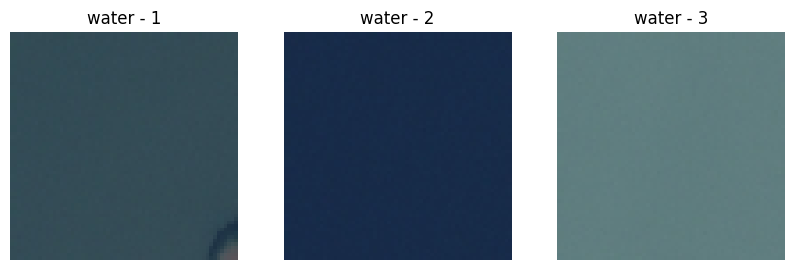

Image dimensions for cloudy: (256, 256)
Image dimensions for desert: (256, 256)
Image dimensions for green_area: (64, 64)
Image dimensions for water: (64, 64)


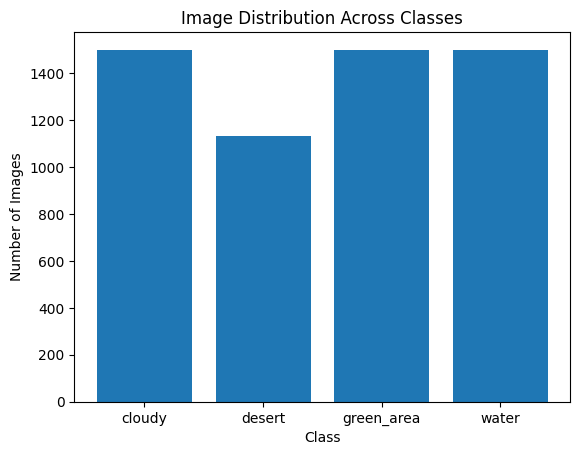

In [11]:
import matplotlib.pyplot as plt
from PIL import Image

labels = os.listdir(base_path_)
labels

class_counts = {}
for class_name in os.listdir(base_path_):
    class_path = os.path.join(base_path_, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

print("Number of images in each class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")
    
def display_sample_images(class_name, num_samples=3):
    class_path = os.path.join(base_path_, class_name)
    image_files = os.listdir(class_path)[:num_samples]

    plt.figure(figsize=(10, 5))
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(class_path, image_file)
        image = Image.open(image_path)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(image)
        plt.title(f'{class_name} - {i+1}')
        plt.axis('off')

    plt.show()

# Display sample images for each class
for class_name in class_counts.keys():
    display_sample_images(class_name)
    
def get_image_dimensions(class_name):
    class_path = os.path.join(base_path_, class_name)
    image_file = os.listdir(class_path)[0]
    image_path = os.path.join(class_path, image_file)
    image = Image.open(image_path)
    return image.size

# Get image dimensions for each class
for class_name in class_counts.keys():
    dimensions = get_image_dimensions(class_name)
    print(f"Image dimensions for {class_name}: {dimensions}")

plt.bar(class_counts.keys(), class_counts.values())
plt.title('Image Distribution Across Classes')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [ ]:
print(X_train_smote.shape)
print(y_train_smote.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

In [2]:
from tensorflow.keras.utils import to_categorical

# One-hot encode the labels
y_train_smote = to_categorical(y_train_smote, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)

In [14]:
import numpy as np
from sklearn.decomposition import PCA

def flatten_images(X):
    """Flatten the images."""
    original_shape = X.shape
    return X.reshape(original_shape[0], -1), original_shape

# Flatten the datasets
X_train_smote_flat, original_shape_train = flatten_images(X_train_smote)
X_test_flat, _ = flatten_images(X_test)
X_val_flat, _ = flatten_images(X_val)

# Number of components for PCA - this is a parameter to be chosen
n_components = 3  # Example value, choose based on your needs

# Initialize PCA with the chosen number of components and whitening
pca = PCA(n_components=n_components, whiten=True)
pca.fit(X_train_smote_flat)

# Transform the datasets
X_train_smote_whitened = pca.transform(X_train_smote_flat)
X_test_whitened = pca.transform(X_test_flat)
X_val_whitened = pca.transform(X_val_flat)


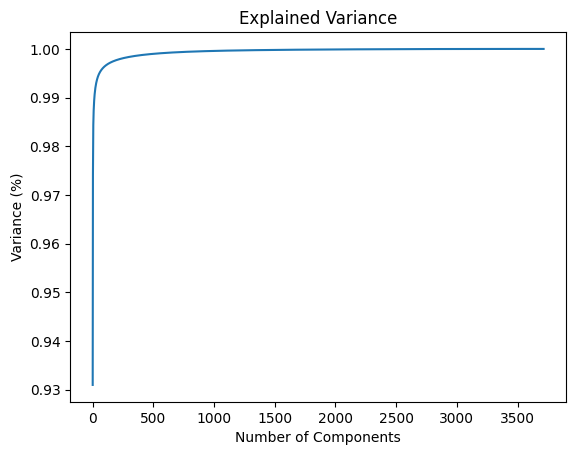

In [6]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming X_train_smote_flat is your flattened training data
pca = PCA().fit(X_train_smote_flat)

# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')  # for each component
plt.title('Explained Variance')
plt.show()

# Choose n_components where the curve starts to plateau

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Number of features in the PCA-transformed data
n_features = X_train_smote_whitened.shape[1]

# Create a Sequential model
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(n_features,)))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Assuming 4 classes in the output

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
np.cumsum(pca.explained_variance_ratio_)

array([0.9309674 , 0.9694986 , 0.97416582, ..., 1.        , 1.        ,
       1.        ])

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.regularizers import l2

# Regularization factor
l2_reg = 0.001

# Number of features in the PCA-transformed data
n_features = X_train_smote_whitened.shape[1]

# Create a Sequential model
model = Sequential()

# Input Layer
model.add(Dense(512, input_shape=(n_features,), kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Hidden Layer 1
model.add(Dense(256, kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Hidden Layer 2
model.add(Dense(128, kernel_regularizer=l2(l2_reg)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(4, activation='softmax'))  # Assuming 4 classes in the output


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 512)               2048      
                                                                 
 batch_normalization_3 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 batch_normalization_4 (Bat  (None, 256)               1024      
 chNormalization)                                     

In [17]:
# Train the model
history = model.fit(
    X_train_smote_whitened, y_train_smote,
    epochs=100,  # Increased epochs for a more complex model
    validation_data=(X_val_whitened, y_val),
    batch_size=64  # Adjusted batch size
)
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_whitened, y_test)
print("Test accuracy:", test_accuracy)

Epoch 1/100
59/59 [==============================] - 4s 10ms/step - loss: 1.2102 - accuracy: 0.7314 - val_loss: 2.3274 - val_accuracy: 0.2398
Epoch 2/100
59/59 [==============================] - 0s 6ms/step - loss: 0.9096 - accuracy: 0.8453 - val_loss: 2.3856 - val_accuracy: 0.2398
Epoch 3/100
59/59 [==============================] - 0s 6ms/step - loss: 0.8399 - accuracy: 0.8568 - val_loss: 2.3891 - val_accuracy: 0.2398
Epoch 4/100
59/59 [==============================] - 0s 6ms/step - loss: 0.8002 - accuracy: 0.8609 - val_loss: 2.4738 - val_accuracy: 0.2398
Epoch 5/100
59/59 [==============================] - 0s 6ms/step - loss: 0.7584 - accuracy: 0.8687 - val_loss: 2.2523 - val_accuracy: 0.2398
Epoch 6/100
59/59 [==============================] - 0s 6ms/step - loss: 0.7172 - accuracy: 0.8727 - val_loss: 2.3451 - val_accuracy: 0.2398
Epoch 7/100
59/59 [==============================] - 0s 6ms/step - loss: 0.6823 - accuracy: 0.8821 - val_loss: 2.3853 - val_accuracy: 0.2398
Epoch 8/100


117/117 [==============================] - 0s 2ms/step


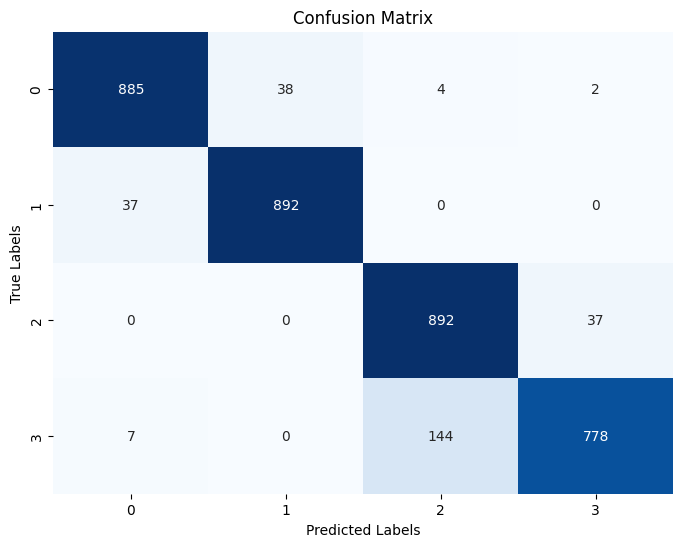

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_train_smote_whitened)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_train_smote, axis=1)

# Create a confusion matrix
confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


36/36 [==============================] - 0s 2ms/step


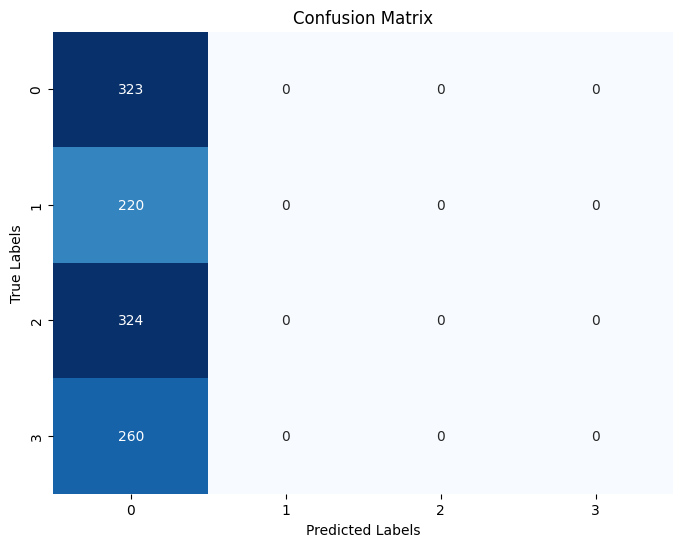

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test_whitened)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Create a confusion matrix
confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [18]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Model architecture
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

# Additional Convolutional Layers
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(layers.Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(256*4, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation='softmax')) 

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_41 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_42 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_43 (Conv2D)          (None, 112, 112, 128)     147584    
                                                     

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

history = model.fit(
    X_train_smote, y_train_smote, 
    epochs=50, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    batch_size = 16
)

Epoch 1/50


2024-01-16 02:24:04.254731: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_55/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


233/233 [==============================] - 43s 153ms/step - loss: 0.9468 - accuracy: 0.5554 - val_loss: 5.4161 - val_accuracy: 0.2398
Epoch 2/50
233/233 [==============================] - 31s 134ms/step - loss: 0.8512 - accuracy: 0.5449 - val_loss: 2.9638 - val_accuracy: 0.2389
Epoch 3/50
233/233 [==============================] - 31s 135ms/step - loss: 0.7555 - accuracy: 0.6259 - val_loss: 2.7482 - val_accuracy: 0.2389
Epoch 4/50
233/233 [==============================] - 31s 135ms/step - loss: 0.6317 - accuracy: 0.6698 - val_loss: 2.4810 - val_accuracy: 0.2398
Epoch 5/50
233/233 [==============================] - 31s 134ms/step - loss: 0.6404 - accuracy: 0.6679 - val_loss: 1.8826 - val_accuracy: 0.2771
Epoch 6/50
233/233 [==============================] - 31s 132ms/step - loss: 0.6114 - accuracy: 0.6768 - val_loss: 1.9058 - val_accuracy: 0.2398
Epoch 7/50
233/233 [==============================] - 31s 132ms/step - loss: 0.5834 - accuracy: 0.7078 - val_loss: 2.3688 - val_accuracy: 0.2

36/36 [==============================] - 5s 67ms/step


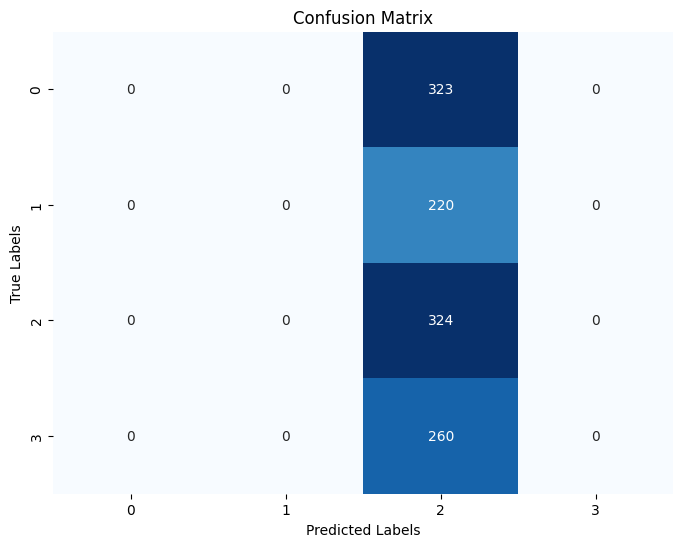

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Create a confusion matrix
confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [4]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Model architecture
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(4, activation='softmax')) 

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0         
                                                                 
 flatten (Flatten)           (None, 802816)            0         
                                                                 
 dense (Dense)               (None, 256)               205521152 
                                                        

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

history = model.fit(
    X_train_smote, y_train_smote, 
    epochs=50, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    batch_size = 16
)

Epoch 1/50


2024-01-16 02:40:18.029015: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


233/233 [==============================] - 27s 96ms/step - loss: 0.6108 - accuracy: 0.7274 - val_loss: 7.3525 - val_accuracy: 0.2398
Epoch 2/50
233/233 [==============================] - 18s 76ms/step - loss: 0.4862 - accuracy: 0.7904 - val_loss: 8.9044 - val_accuracy: 0.2398
Epoch 3/50
233/233 [==============================] - 19s 81ms/step - loss: 0.4562 - accuracy: 0.8068 - val_loss: 6.6209 - val_accuracy: 0.2398
Epoch 4/50
233/233 [==============================] - 19s 80ms/step - loss: 0.4532 - accuracy: 0.8159 - val_loss: 5.2292 - val_accuracy: 0.2398
Epoch 5/50
233/233 [==============================] - 19s 81ms/step - loss: 0.4288 - accuracy: 0.8286 - val_loss: 4.3215 - val_accuracy: 0.2762
Epoch 6/50
233/233 [==============================] - 19s 80ms/step - loss: 0.4227 - accuracy: 0.8259 - val_loss: 3.8148 - val_accuracy: 0.1226
Epoch 7/50
233/233 [==============================] - 18s 76ms/step - loss: 0.3814 - accuracy: 0.8415 - val_loss: 32.5699 - val_accuracy: 0.2105
Ep

36/36 [==============================] - 2s 26ms/step


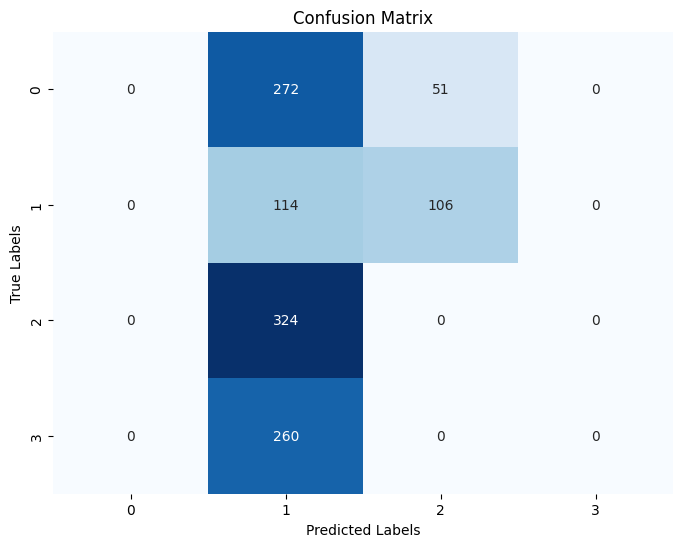

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Create a confusion matrix
confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [7]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

# Load pre-trained EfficientNetB7 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = models.Sequential()

# Add the EfficientNet model
model.add(base_model)

# Add new pooling layer
model.add(layers.GlobalAveragePooling2D())

# Add new fully connected layers
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_2 (Dense)             (None, 1024)              1311744   
                                                                 
 batch_normalization_1 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                      

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [9]:
history = model.fit(
    X_train_smote, y_train_smote, 
    epochs=50, 
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    batch_size = 16
)

Epoch 1/50


2024-01-16 02:46:20.257098: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


233/233 [==============================] - 23s 58ms/step - loss: 2.1026 - accuracy: 0.2605 - val_loss: 1.5303 - val_accuracy: 0.2735
Epoch 2/50
233/233 [==============================] - 9s 37ms/step - loss: 1.7275 - accuracy: 0.2777 - val_loss: 1.6313 - val_accuracy: 0.2105
Epoch 3/50
233/233 [==============================] - 9s 37ms/step - loss: 1.5588 - accuracy: 0.3132 - val_loss: 2.5568 - val_accuracy: 0.2105
Epoch 4/50
233/233 [==============================] - 9s 37ms/step - loss: 1.4346 - accuracy: 0.3509 - val_loss: 2.7400 - val_accuracy: 0.2735
Epoch 5/50
233/233 [==============================] - 9s 37ms/step - loss: 1.3238 - accuracy: 0.3821 - val_loss: 2.1442 - val_accuracy: 0.2105
Epoch 6/50
233/233 [==============================] - 9s 37ms/step - loss: 1.2578 - accuracy: 0.3819 - val_loss: 1.4343 - val_accuracy: 0.2398
Epoch 7/50
233/233 [==============================] - 8s 36ms/step - loss: 1.2118 - accuracy: 0.4198 - val_loss: 2.0722 - val_accuracy: 0.2105
Epoch 8/5

36/36 [==============================] - 4s 52ms/step


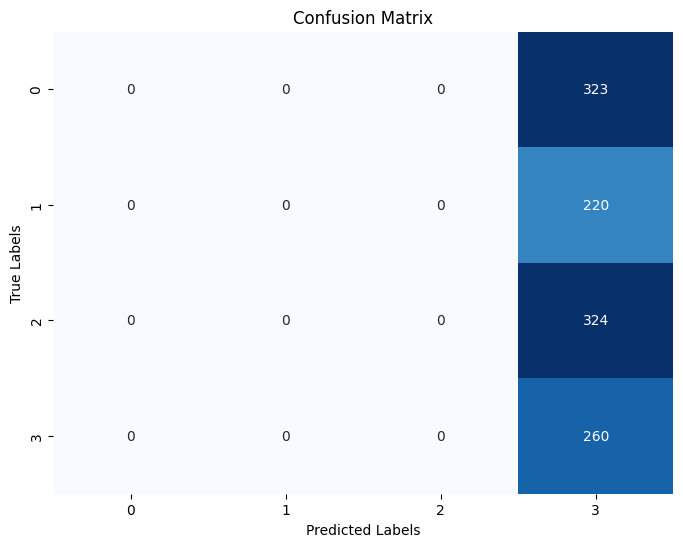

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Create a confusion matrix
confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [11]:
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input 
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

# Initialize MobileNetV2 base model
base_model = MobileNetV2(input_shape=[224, 224, 3], weights='imagenet', include_top=False)

# Freeze the first 100 layers
for layer in base_model.layers[:100]:
    layer.trainable = False

# Regularization factor
l2_reg = 0.1

# Additional layers with regularization
pool = GlobalAveragePooling2D()
mid_layer = Dense(32, activation='relu', kernel_regularizer=l2(l2_reg))
dropout = Dropout(0.7)  # Dropout rate can be adjusted
final_layer = Dense(4, activation='softmax')  # Assuming 4 classes

# Assemble the model
model = Sequential([
    base_model,
    pool,
    mid_layer,
    dropout,  # Add dropout after the dense layer
    final_layer
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 32)                40992     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 4)                 132       
                                                                 
Total params: 2299108 (8.77 MB)
Trainable params: 1902

In [12]:
history = model.fit(
    X_train_smote, y_train_smote, 
    epochs=50, 
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    batch_size = 16
)

Epoch 1/50
233/233 [==============================] - 24s 49ms/step - loss: 1.7408 - accuracy: 0.8369 - val_loss: 9.2541 - val_accuracy: 0.2307
Epoch 2/50
233/233 [==============================] - 7s 32ms/step - loss: 0.4686 - accuracy: 0.8733 - val_loss: 18.5302 - val_accuracy: 0.2307
Epoch 3/50
233/233 [==============================] - 8s 33ms/step - loss: 0.3884 - accuracy: 0.8940 - val_loss: 7.3607 - val_accuracy: 0.2875
Epoch 4/50
233/233 [==============================] - 8s 33ms/step - loss: 0.4689 - accuracy: 0.8698 - val_loss: 11.7634 - val_accuracy: 0.2307
Epoch 5/50
233/233 [==============================] - 8s 33ms/step - loss: 0.4648 - accuracy: 0.8644 - val_loss: 9.9953 - val_accuracy: 0.2307
Epoch 6/50
233/233 [==============================] - 7s 32ms/step - loss: 0.4595 - accuracy: 0.8574 - val_loss: 12.8333 - val_accuracy: 0.2307
Epoch 7/50
233/233 [==============================] - 7s 32ms/step - loss: 0.4115 - accuracy: 0.8679 - val_loss: 16.7874 - val_accuracy: 0

36/36 [==============================] - 2s 29ms/step


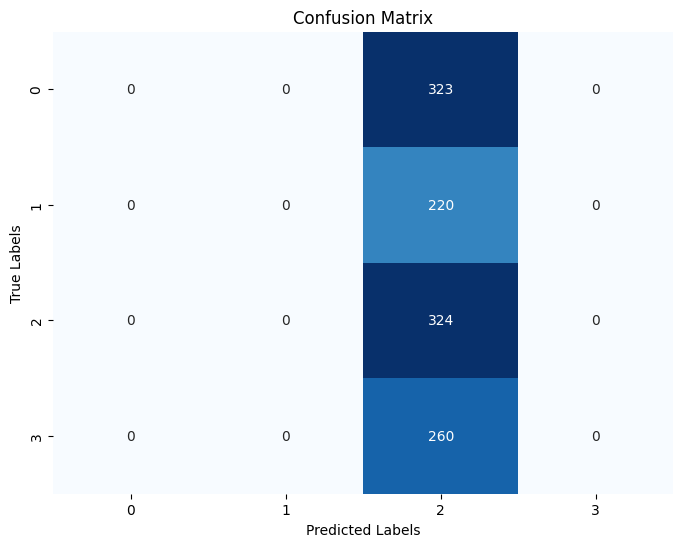

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Create a confusion matrix
confusion_mtx = confusion_matrix(y_true_classes, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [23]:
from tensorflow.keras import backend as K
K.clear_session()

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers, callbacks, metrics

class SimpleResidualBlock(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = layers.Conv2D(3, 3, strides=1, padding='same')
        self.relu1 = layers.ReLU()
        self.conv2 = layers.Conv2D(3, 3, strides=1, padding='same')
        self.relu2 = layers.ReLU()

    def call(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x

def conv_block(in_channels, out_channels, pool=False):
    layers_list = [
        layers.Conv2D(out_channels, 3, padding='same'),
        layers.BatchNormalization(),
        layers.ReLU()
    ]
    if pool:
        layers_list.append(layers.MaxPooling2D())
    return models.Sequential(layers_list)

class ResNet9(tf.keras.Model):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = conv_block(3, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = models.Sequential([conv_block(128, 128), conv_block(128, 128)])
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = models.Sequential([conv_block(512, 512), conv_block(512, 512)])
        
        self.classifier = models.Sequential([
            layers.GlobalMaxPooling2D(), 
            layers.Flatten(), 
            layers.Dropout(0.2),
            layers.Dense(num_classes, activation='softmax')
        ])
        
    def call(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        return self.classifier(out)


def train_step(model, images, labels, loss_fn, optimizer, train_acc_metric):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_fn(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_acc_metric.update_state(labels, predictions)
    return loss

def test_step(model, images, labels, loss_fn, val_acc_metric):
    predictions = model(images, training=False)
    loss = loss_fn(labels, predictions)
    val_acc_metric.update_state(labels, predictions)
    return loss

def fit_one_cycle(model, epochs, max_lr, train_dataset, val_dataset, weight_decay=0.0, grad_clip=None):
    optimizer = optimizers.Adam(learning_rate=max_lr)
    loss_fn = losses.CategoricalCrossentropy(from_logits=False)
    train_acc_metric = metrics.CategoricalAccuracy()
    val_acc_metric = metrics.CategoricalAccuracy()
    history = []

    for epoch in range(epochs):
        # Reset the metrics at the start of the next epoch
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()

        # Training loop
        for images, labels in train_dataset:
            train_loss = train_step(model, images, labels, loss_fn, optimizer, train_acc_metric)

        # Validation loop
        val_loss = 0.0
        for images, labels in val_dataset:
            val_loss += test_step(model, images, labels, loss_fn, val_acc_metric)

        val_loss /= len(val_dataset)
        train_acc = train_acc_metric.result()
        val_acc = val_acc_metric.result()
        print(f'Epoch {epoch}, Train Loss: {train_loss}, Train Accuracy: {train_acc}, Val Loss: {val_loss}, Val Accuracy: {val_acc}')
        history.append({'train_loss': train_loss, 'train_acc': train_acc, 'val_loss': val_loss, 'val_acc': val_acc})

    return model, history

model = ResNet9(num_classes=4)
epochs = 10
max_lr = 0.001
trained_model, history = fit_one_cycle(model, epochs, max_lr, train_dataset, val_dataset)

Epoch 0, Train Loss: 2.1630654335021973, Train Accuracy: 0.7088267207145691, Val Loss: 1.9866083860397339, Val Accuracy: 0.23978686332702637
Epoch 1, Train Loss: 0.08911963552236557, Train Accuracy: 0.7701829671859741, Val Loss: 2.9624414443969727, Val Accuracy: 0.23978686332702637
Epoch 2, Train Loss: 1.528351902961731, Train Accuracy: 0.7863293886184692, Val Loss: 1.4593509435653687, Val Accuracy: 0.2548845410346985
Epoch 3, Train Loss: 0.28058940172195435, Train Accuracy: 0.8175457715988159, Val Loss: 2.1621904373168945, Val Accuracy: 0.2761989235877991
Epoch 4, Train Loss: 1.6499333381652832, Train Accuracy: 0.8301937580108643, Val Loss: 1.9228401184082031, Val Accuracy: 0.21047957241535187
Epoch 5, Train Loss: 0.08526941388845444, Train Accuracy: 0.8382669687271118, Val Loss: 3.2299275398254395, Val Accuracy: 0.2761989235877991
Epoch 6, Train Loss: 0.27810952067375183, Train Accuracy: 0.8552206754684448, Val Loss: 3.5287458896636963, Val Accuracy: 0.2761989235877991
Epoch 7, Train

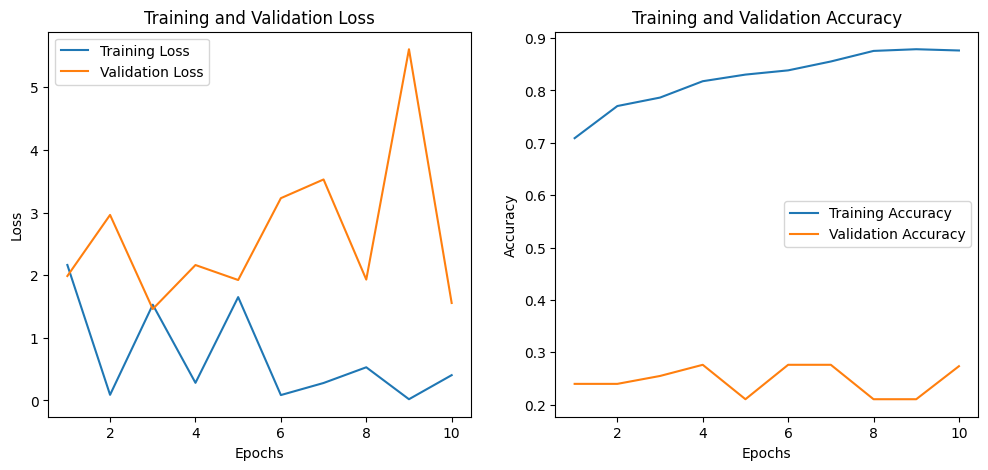

In [17]:
import matplotlib.pyplot as plt

def plot_history(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    train_accuracies = [x['train_acc'] for x in history]
    val_accuracies = [x['val_acc'] for x in history]

    epochs = range(1, len(history) + 1)

    # Plotting Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Example usage:
# Assuming 'history' is returned from your training function
plot_history(history)